In [22]:
%matplotlib inline

import numpy as np

import pandas as pd
from pandas_datareader import data

import matplotlib.pyplot as plt
import matplotlib.finance as mfinance
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.transforms as mtransforms

from statsmodels import stats
import scipy.optimize as opt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression,LinearRegression

In [6]:
symbol = 'GOOG'
from_date = '2016-01-01'
to_date = '2016-03-31'
goog_data = data.DataReader(symbol,'yahoo',from_date,to_date)

In [42]:
def show_chart(prices,indicators=None,moving_average=None,buying_history=None,selling_history=None):

    dates = [ mdates.date2num(date) for date in prices.index]
    open_prices = prices['Open']
    high_prices = prices['High']
    low_prices = prices['Low']
    close_prices = prices['Close']
    volumes = prices['Volume'] if 'Volume' in prices.columns else None

    chart_data = np.matrix([dates,open_prices,high_prices,low_prices,close_prices]).T.tolist()

    fig = plt.figure()
    ax1 = plt.subplot2grid((5,4),(0,0),rowspan=4,colspan=4)
    mfinance.candlestick_ohlc(ax1,chart_data,colorup='r',colordown='b',alpha=0.7)
    ax1.grid(True)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    plt.ylabel('Price')
    ax2 = plt.subplot2grid((5,4),(4,0),sharex=ax1,rowspan=1,colspan=4)
    ax2.grid(True)

    if buying_history is not None and len(buying_history) > 0:
        dx, dy = -3/72., 0.
        offset = mtransforms.ScaledTranslation(dx, dy,fig.dpi_scale_trans)
        shadow_transform = ax1.transData + offset

        buying_dates = [ mdates.date2num(date) for date in buying_history.index]
        ax1.plot(buying_dates,buying_history.values,'r>',transform=shadow_transform)

    if selling_history is not None and len(selling_history) > 0:
        dx, dy = +3/72., 0.
        offset = mtransforms.ScaledTranslation(dx, dy,fig.dpi_scale_trans)
        shadow_transform = ax1.transData + offset

        selling_dates = [ mdates.date2num(date) for date in selling_history.index]
        ax1.plot(selling_dates,selling_history.values,'b<',transform=shadow_transform)

    if moving_average is not None:
        for w in moving_average:
            ma = sma(close_prices,w)
            ax1.plot(dates[-len(ma):],ma)

    if indicators is not None and 'bollinger' in indicators:
        middle,upper,lower = bollinger_bands(close_prices)
        ax1.plot(dates[-len(middle):],middle)
        ax1.plot(dates[-len(upper):],upper)
        ax1.plot(dates[-len(lower):],lower)
    if indicators is not None and 'macd' in indicators:
        macd_line,macd_signal,macd_hist,ma_long,ma_short = macd(close_prices)
        ax2.plot(dates[-len(macd_line):],macd_line)
        ax2.plot(dates[-len(macd_signal):],macd_signal)
        ax2.bar(dates[-len(macd_hist):],macd_hist)
        ax2.axes.yaxis.set_ticklabels([])
        plt.ylabel('MACD')
    elif indicators is not None and 'rsi' in indicators:
        r,s = rsi(close_prices)
        ax2.plot(dates[-len(r):],r)
        ax2.plot(dates[-len(s):],s)
        plt.ylabel('RSI')
    elif volumes is not None:
        plt.ylabel('Volume')
        ax2.bar(dates[-len(volumes):],volumes)
        ax2.axes.yaxis.set_ticklabels([])

    fig.subplots_adjust(hspace=0)
    plt.setp( plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.setp(ax1.get_xticklabels(),visible=False)
    ax1.set_yticks(ax1.get_yticks()[1:])
    return ax1,ax2
#     plt.show()


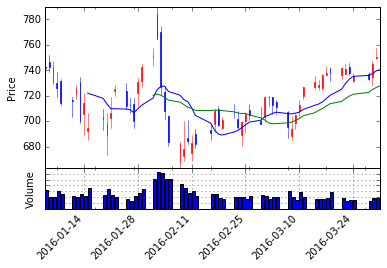

In [46]:
ax1,ax2 = show_chart(goog_data[goog_data.columns[:5]])
pd.rolling_mean(goog_data['Close'],window=10)[9:].plot(ax=ax1)
pd.rolling_mean(goog_data['Close'],window=20)[19:].plot(ax=ax1)